In [1]:
%matplotlib inline

In [2]:
# Change to the test case directory
from os import chdir
chdir('testcase_hires')

In [3]:
# Restore the case
from uetools import Case
c = Case('input.yaml')

No UETOOLS config file found: Configure file by calling Case().config.create() or uetools.config.create()
Alternatively, manually create the .uetoolsrc configuration YAML in your home directory.
UETOOLS-style save successfully restored from .../jupyter/testcase_hires/nc20.hdf5

*** UEDGE arrays populated: Case appears converged ***
fnrm without preconditioning: 2.27e+00



# DIII-D experiment

Note that the UEDGE grid is shifted by 1.6m in the vertical (z) direction relative to experiment. 
We therefore correct for this shift when loading the experiment configuration.

The wall 'wall1_bol' has been modified to enable the bolometer system to 'see' the plasma.

In [4]:
experiment = c.cherab.d3d(zshift = 1.6).add_wall('wall1_bol')

# Check geometry alignment

Visually check that the mesh, wall and bolometer geometry are aligned.

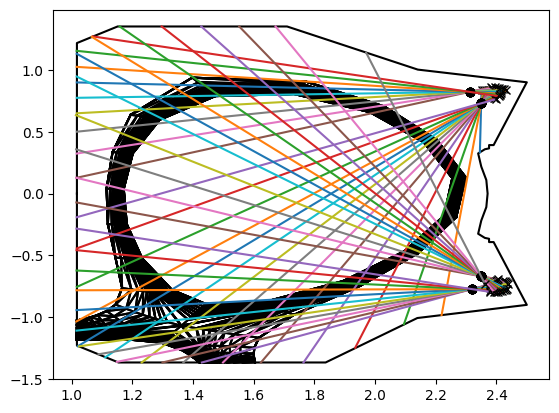

<AxesSubplot:>

In [5]:
import matplotlib.pyplot as plt
plt.ion()
ax = c.cherab.plot_triangles()
experiment.wall.plotRZ(ax=ax, show=False)
experiment.bolometer.plotLinesOfSight(ax=ax)

# Calculate sensitivity

This is sometimes called a geometry matrix: It's a matrix that relates emission from each cell to the power measured on each bolometer foil. Since there are many more cells than bolometer foils, this is a non-square matrix.

Calculating a sensitivity matrix is slow, but comparable to calculating the bolometer measurements once. Both use ray tracing from the bolometer foils through the UEDGE mesh.

Once calculated, the sensitivity matrix can be used to:
- Quickly calculate bolometer power by doing a single matrix-vector product
- Calculate changes to the radiation profile that don't change the measurements
- Invert bolometer measurements to estimate emission [Requires a regularization]

Note: Higher ray counts should probably be used in practice to get accurate coefficients.

In [6]:
sens = experiment.bolometer.sensitivity(ray_count = 10)

The `sens.matrix` property returns a NumPy array. The first index is the number of bolometer foils; the second is the cell number.

In [7]:
sens.matrix.shape

(48, 612)

Quickly measure the power radiated using `sens.measure()`

In [8]:
sens.measure(c.get('prad'))

array([0.00000000e+00, 4.11210234e-06, 2.26602111e-05, 9.56676900e-06,
       2.64206036e-05, 1.34050350e-05, 2.12040262e-03, 1.82640794e-04,
       2.38232386e-04, 1.13439028e-04, 2.43419466e-04, 1.72423542e-04,
       3.10175936e-05, 3.10917176e-05, 3.10546674e-05, 1.83946288e-05,
       4.30660271e-05, 7.08141730e-05, 6.96932096e-05, 9.22173434e-05,
       2.99054314e-05, 7.45032176e-06, 0.00000000e+00, 0.00000000e+00,
       5.29253350e-03, 1.08527803e-03, 2.32848335e-04, 3.44810953e-04,
       6.54631611e-04, 3.30813809e-03, 7.99272433e-04, 7.76137713e-05,
       3.76372554e-05, 3.45481743e-05, 3.67672497e-05, 3.40597138e-05,
       3.36750602e-05, 3.56040170e-05, 4.55713629e-05, 9.00060049e-06,
       9.68850034e-06, 1.66848633e-05, 8.56427865e-06, 1.23600520e-05,
       5.76186214e-06, 1.09256529e-05, 1.59177893e-05, 5.16269720e-05])

# Projecting onto bolometer nullspace

Using SVD, we calculate components of the radiation field that have no impact on bolometer measurements. This is the null space of the measurement matrix.

The method `project_nullspace()` takes a 2D (nx, ny) radiation field, or change in radiation field, and projects it onto the bolometer nullspace. The returned radiation field therefore has no effect on the bolometer measurements.

In [9]:
prad_null = sens.project_nullspace(c.get('prad'))

/Users/dudson2/code/UETOOLS/src/uetools/UePlot/CasePlot.py:608: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


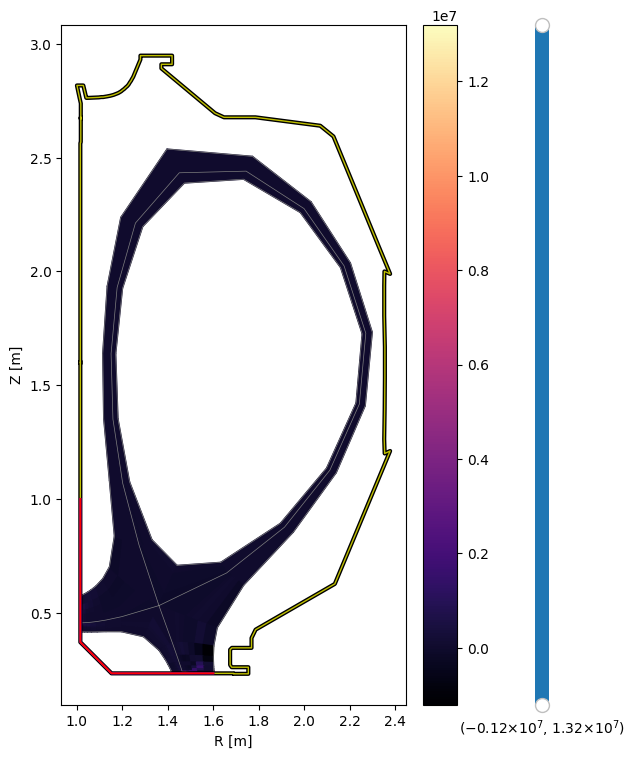

In [10]:
c.plot.variablemesh(prad_null)
plt.show()

In [11]:
# The bolometers don't measure any significant contribution from `prad_null`
sens.measure(prad_null)

array([ 0.00000000e+00, -2.86403015e-19, -5.42948119e-19,  1.75759337e-19,
        1.07403778e-18, -7.05154929e-19, -9.21571847e-19,  4.63327022e-19,
        1.26716129e-18,  1.20448085e-18,  1.55176436e-18,  1.39591030e-18,
        4.29826869e-18,  4.19111902e-18, -1.61952700e-18, -6.67673721e-18,
       -1.05032085e-19, -3.95310276e-18, -1.63138546e-18, -1.67881930e-18,
       -3.06287114e-18, -4.90749714e-19,  0.00000000e+00,  0.00000000e+00,
       -5.42101086e-18,  2.65629532e-18,  4.33680869e-19,  3.00866103e-18,
        4.87890978e-18,  6.90636784e-17, -6.10947924e-17,  5.14996032e-18,
        3.55753838e-18,  9.12085078e-18, -4.35205528e-18,  2.24802544e-18,
        2.65460126e-18, -6.43745040e-20,  2.18703907e-18,  4.42362957e-19,
        5.58618229e-19,  4.09011034e-19, -1.17684640e-19,  3.35001531e-19,
       -5.32571966e-19,  1.41878019e-19, -9.60958879e-19,  9.57824857e-18])